In [72]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [73]:
#read train and test csv file into pandas dataframe object
train = pd.read_csv('./train.csv', index_col= 0)
test = pd.read_csv('./test.csv',index_col=0)

In [74]:
#visualize train dataframe object
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [75]:
#visualize test dataframe object
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [76]:
#Now what we have to do is to start making some changes to the train data. Test data we will leave it for a while and 
#come back later, we have to first find out how many missing value are in each category. This is something we must find 
#if we want to engineer the data a little bit in the future
train.isnull().sum()


Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [77]:
#Drop column that seem not helpful for prediction like Embarked, Name. For testing data we have to do the same
newtrain = train.drop(['Embarked','Cabin', 'Name', 'Ticket'], axis=1)
newtest = test.drop(['Embarked','Cabin', 'Name', 'Ticket'], axis=1)
newtrain.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,,,,,,,
1,0,3,male,22.0,1,0,7.2500
2,1,1,female,38.0,1,0,71.2833
3,1,3,female,26.0,0,0,7.9250
4,1,1,female,35.0,1,0,53.1000
5,0,3,male,35.0,0,0,8.0500


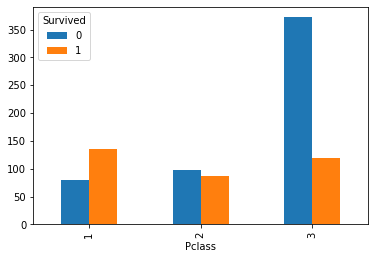

In [78]:
#Now let's visualize the correlation between each column and the survival rate
#First let's start with Pclass, let's visualize the survival rate between different classes

newtrain.groupby(['Pclass', 'Survived']).size().unstack(fill_value=0).plot.bar()


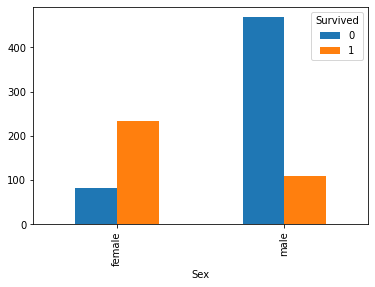

In [79]:
#We do the same thing for gender
newtrain.groupby(['Sex', 'Survived']).size().unstack(fill_value=0).plot.bar()

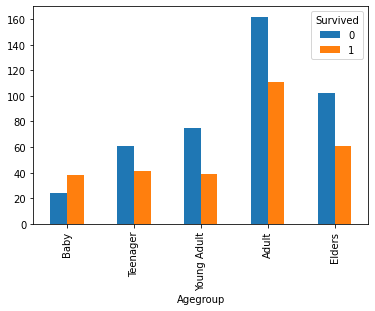

In [80]:
#Same thing for age, however we ignored the missing value
temp = newtrain[newtrain['Age'].notnull()].copy(deep = True)
bins = [0, 10, 20, 25, 40, np.Inf]
group_name = ['Baby', 'Teenager', 'Young Adult', 'Adult', 'Elders']
temp['Agegroup'] = pd.cut(temp['Age'], bins=bins, labels=group_name, right=False)

temp.groupby(['Agegroup', 'Survived']).size().unstack(fill_value=0).plot.bar()

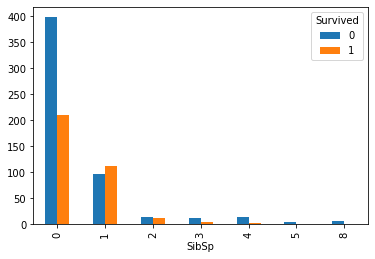

In [81]:
#Now let's check with sibling count
newtrain.groupby(['SibSp', 'Survived']).size().unstack(fill_value=0).plot.bar()


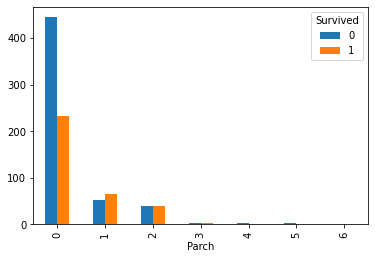

In [82]:
#Now let's check with parch correlation
newtrain.groupby(['Parch', 'Survived']).size().unstack(fill_value=0).plot.bar()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000224393FEB80>]],
      dtype=object)

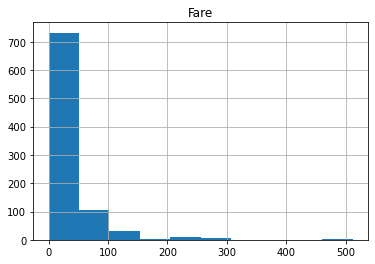

In [83]:
#Visualize the distribution of fare so we can group it in the future
newtrain.hist(column="Fare")

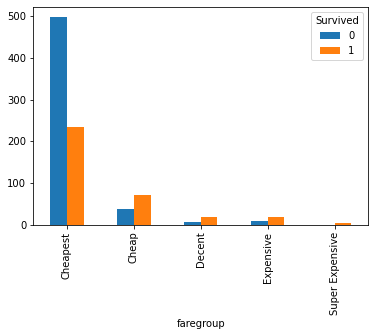

In [84]:
#Show the correlation between fare and survival rate
tempfare = newtrain.copy(deep = True)
bins = [0, 50, 100, 150, 300, np.Inf]
group_name = ['Cheapest', 'Cheap', 'Decent', 'Expensive', 'Super Expensive']
tempfare['faregroup'] = pd.cut(tempfare['Fare'], bins=bins, labels=group_name, right=False)

tempfare.groupby(['faregroup', 'Survived']).size().unstack(fill_value=0).plot.bar()


In [85]:
#Now we finished visualizing the data, now let's try to fill the missing value from age
#There can be many approch to filling na value. And it will be whole another topic if 
#we want to go through. So here I will process the data with most naive one, then with a better one and
#let's see the result

In [86]:
#for the naive one we can just replace the missing age range with mean age of all people
naivetrain = newtrain.copy(deep = True)
meanage = naivetrain['Age'].mean()
naivetrain.loc[naivetrain['Age'].isnull(), 'Age'] = meanage
naivetrain.isnull().sum()


Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
dtype: int64

In [87]:
#Before starting the training. We have to separate the label out

naivelabel = naivetrain['Survived']
naivetrain.drop(['Survived'], axis=1, inplace=True)




In [88]:
#Now we start processing the data since machine learning works best with numbers not string. So we replace sex
#with one hot vector. Here we import some library to help us do the task and define the transformer.

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer([('Encoder', OneHotEncoder(), ['Sex'])], remainder='passthrough')

In [89]:
# Before transformation
naivetrain.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,,,,,,
1,3,male,22.0,1,0,7.2500
2,1,female,38.0,1,0,71.2833
3,3,female,26.0,0,0,7.9250
4,1,female,35.0,1,0,53.1000
5,3,male,35.0,0,0,8.0500


In [90]:
#After transformation
naivetrain = pd.DataFrame(ct.fit_transform(naivetrain))
naivetrain.head()

,0,1,2,3,4,5,6
0,0.0,1.0,3.0,22.0,1.0,0.0,7.2500
1,1.0,0.0,1.0,38.0,1.0,0.0,71.2833
2,1.0,0.0,3.0,26.0,0.0,0.0,7.9250
3,1.0,0.0,1.0,35.0,1.0,0.0,53.1000
4,0.0,1.0,3.0,35.0,0.0,0.0,8.0500


In [91]:
#Now we can start training. Remember because of the property of decision tree, we don't need to normalize the data.
#However if you use other method. It's best for you to normalize it

In [92]:
#We first import the decision tree model
from sklearn import tree

In [93]:
#Train the model and use cross validation to get the prediction score
from sklearn.model_selection import cross_val_score

clf = tree.DecisionTreeClassifier()
cross_val_score(clf, naivetrain, naivelabel)


array([0.70391061, 0.80337079, 0.80898876, 0.76404494, 0.80337079])

In [94]:
#Now we can also visualize the tree, since the real tree will be too big. We will add some constrain to the depth of the tree

import graphviz



newclf = tree.DecisionTreeClassifier(max_depth = 4)
newclf.fit(naivetrain, naivelabel)



fn=["Not Male", "Not Female", "Pclass", "Age", "Sibling count", "Parch", "Fare"]
cn=["Didn't survived", "Survived"]

tree.export_graphviz(newclf,
                     out_file="tree.dot",
                     feature_names = fn, 
                     class_names=cn,
                     filled = True)



In [95]:
#Can we improve it? What happen if instead of filling the missing value using the average age from whole population
#We instead separate them by gender?



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000224391941C0>]],
      dtype=object)

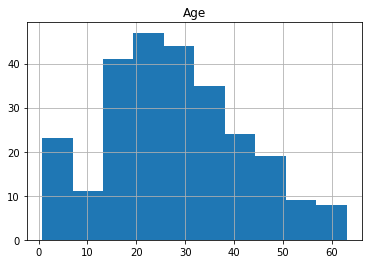

In [96]:
#But first we need to see the age distribution between different gender
female = newtrain[newtrain['Sex'] == 'female']
female.hist(column="Age")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000224394D7040>]],
      dtype=object)

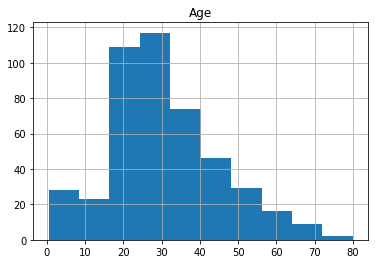

In [97]:
male = newtrain[newtrain['Sex'] == 'male']
male.hist(column="Age")

In [98]:
#As you can see the average age of male should be greater than female based on the histgram. So if we use the average age of 
#the same gender we should get a better accuracy

maleaverage = newtrain[newtrain['Sex'] == 'male']['Age'].mean()
maleaverage

30.72664459161148

In [99]:
femaleaverage = newtrain[newtrain['Sex'] == 'female']['Age'].mean()
femaleaverage

27.915708812260537

In [100]:
#As you can see there is a different in the average, Now let's fill the missing data
newtrain.loc[(train['Sex'] == 'male') & (train['Age'].isnull()), 'Age'] = maleaverage
newtrain.loc[(train['Sex'] == 'female') & (train['Age'].isnull()), 'Age'] = femaleaverage


In [101]:
#Then we do the same thing and prepare the model also use cross validation to validate the prediction score, this is the 
#same prep work
label = newtrain['Survived']
newtrain.drop(['Survived'], axis=1, inplace=True)
newtrain = pd.DataFrame(ct.fit_transform(newtrain))
newtrain.head()

,0,1,2,3,4,5,6
0,0.0,1.0,3.0,22.0,1.0,0.0,7.2500
1,1.0,0.0,1.0,38.0,1.0,0.0,71.2833
2,1.0,0.0,3.0,26.0,0.0,0.0,7.9250
3,1.0,0.0,1.0,35.0,1.0,0.0,53.1000
4,0.0,1.0,3.0,35.0,0.0,0.0,8.0500


In [102]:
betterclf = tree.DecisionTreeClassifier()
cross_val_score(betterclf, newtrain, label)

array([0.69832402, 0.79775281, 0.80337079, 0.76404494, 0.76966292])

In [105]:
#It seem like the model score didn't really improved by a lot. And this is expected. 
#Although we try to fill the missing data with more appropriate value. The average is
#still really close between two population. I don't want to go too deep about data
#engineering. But something we can try is can we separate the population group even more?
#Take a look at their name

child = train[train['Age'] < 10]
child.head()


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
17,0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.1250,NaN,Q
25,0,3,"Palsson, Miss. Torborg Danira",female,8.0,3,1,349909,21.0750,NaN,S
44,1,2,"Laroche, Miss. Simonne Marie Anne Andree",female,3.0,1,2,SC/Paris 2123,41.5792,NaN,C


In [106]:
#We can see for young male they have master in their name. This is something we can utilize and separate 
#the group even more.

In [107]:
#After we done with decision tree, let's talk about random forest. What's the biggest problem of decision tree. It overfits
#the data by a lot. So we can improve the model using random forest. Take a look at the score. It defintely improved by a lot
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
cross_val_score(clf, newtrain, label)

array([0.75977654, 0.80898876, 0.86516854, 0.78089888, 0.84269663])